In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

x_train = pd.read_csv('data/features_scaled_with_prev.csv').drop('Unnamed: 0', axis=1)

x_test = pd.read_csv('data/test_data_scaled_with_prev.csv').drop('Unnamed: 0', axis=1)

y = pd.read_csv('data/target_scaled_with_prev.csv').drop('Unnamed: 0', axis=1)
y_dist = pd.read_csv('data/y_new_distribution.csv').drop('Unnamed: 0', axis=1)

mu_y = y_dist['mu_y'].values
sigma_y = y_dist['sigma_y'].values

# Frequentist

First, we use OLS to get a frequentist interprestation of linear regression. This will only be for features, not PCA.

### Regular Features

In [18]:
# Initialize linear regression
import statsmodels.api as sm

x_train_with_intercept = sm.add_constant(x_train)

lg_regular = sm.OLS(y, x_train_with_intercept)

# fit on data
lg_regular_fit = lg_regular.fit()


print(lg_regular_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     115.8
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           2.04e-09
Time:                        02:16:52   Log-Likelihood:                 14.015
No. Observations:                  19   AIC:                            -12.03
Df Residuals:                      11   BIC:                            -4.475
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0395      0.06

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [19]:
# do actual prediction with sklearn
from sklearn.linear_model import LinearRegression

lg_regular_sk = LinearRegression().fit(x_train, y)


print(f'Predicted value: {(lg_regular_sk.predict(x_test) * sigma_y + mu_y)[0][0]:.2f}')

Predicted value: 902.37


# Bayesian

Now, we will us MCMC to find a distribution for the year of 2023. We will follow the setup:

$$y = \boldsymbol{\beta_1} \mathbf{X} + \beta_0 + \epsilon$$

Where

$$\boldsymbol{\beta_1} \sim N_p(0, I)$$
$$\beta_0 \sim N(0, 10000)$$
$$\epsilon \sim C$$

are our priors.

In [153]:
x_train

,gdp,population,unemployment_rate,interest_rate,inflation_rate,real_estate_sales
0,-1.549521,-1.739085,-0.053323,-0.216460,-0.417579,-1.210888
1,-1.343705,-1.548823,-0.213292,0.345068,0.554866,-0.859513
2,-1.121316,-1.354759,-0.479906,1.594921,0.554866,-0.580041
3,-0.911270,-1.159646,-0.746521,2.349663,-0.303174,-0.396891
4,-0.733080,-0.959178,-0.426583,1.890779,1.012487,-0.490501
5,-0.653099,-0.761311,0.799844,-0.584774,-0.817998,-0.708924
6,-0.732043,-0.572453,2.186239,-0.747798,-0.417579,-0.858156
7,-0.577591,-0.393404,1.866302,-0.705533,-0.817998,-0.968046
8,-0.428584,-0.212816,1.439718,-0.771950,0.497663,-1.008746
9,-0.251584,-0.026801,1.119781,-0.723647,-0.417579,-0.581397


### Regular Features

In [21]:
y = y.values.reshape(19, )

In [22]:
with pm.Model() as simulated_model:
    # set distirbutions
    error = pm.Cauchy('error', 0, 1)
    intercept = pm.Normal('intercept', 0, 1)
    gdp = pm.Normal('gdp', 0, 1)
    population = pm.Normal('population', 0, 1)
    unem_rate = pm.Normal('unem_rate', 0, 1)
    interest_rate = pm.Normal('interest_rate', 0, 1)
    inflation_rate = pm.Normal('inflation_rate', 0, 1)
    re_sales = pm.Normal('re_sales', 0, 1)

    gdp_o = pm.MutableData('gdp_o', x_train['gdp'])
    population_o = pm.MutableData('population_o', x_train['population'])
    unem_rate_o = pm.MutableData('unem_rate_o', x_train['unemployment_rate'])
    interest_rate_o = pm.MutableData('interest_rate_o', x_train['interest_rate'])
    inflation_rate_o = pm.MutableData('inflation_rate_o', x_train['inflation_rate'])
    re_sales_o = pm.MutableData('re_sales_o', x_train['real_estate_sales'])


    res = pm.Normal('res', gdp * gdp_o \
                  + population * population_o \
                    + unem_rate * unem_rate_o \
                        + interest_rate * interest_rate_o \
                            + inflation_rate * inflation_rate_o \
                                + re_sales * re_sales_o + intercept, error, observed=y)


    

In [23]:
with simulated_model:
    simulated_trace = pm.sample(draws=4000, tune=5000, chains=4, target_accept=0.90, random_state=109) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, gdp, population, unem_rate, interest_rate, inflation_rate, re_sales]


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 34 seconds.


In [24]:
pm.summary(simulated_trace, var_names=['intercept', 'error', 'gdp', 'population', 'unem_rate', 'interest_rate', 'inflation_rate', 're_sales'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.081,0.039,-0.152,-0.006,0.000,0.000,12156.0,9155.0,1.0
error,0.166,0.038,0.102,0.233,0.001,0.000,6381.0,6613.0,1.0
gdp,0.244,0.435,-0.557,1.072,0.006,0.004,6033.0,7772.0,1.0
population,0.301,0.323,-0.308,0.917,0.004,0.003,6138.0,8276.0,1.0
unem_rate,0.063,0.067,-0.062,0.191,0.001,0.001,8984.0,9523.0,1.0
interest_rate,-0.020,0.071,-0.155,0.114,0.001,0.001,9307.0,9543.0,1.0
inflation_rate,0.131,0.069,-0.001,0.261,0.001,0.000,9880.0,9620.0,1.0
re_sales,0.488,0.213,0.099,0.897,0.002,0.002,7592.0,8651.0,1.0


In [25]:
with simulated_model:
    hat_data = pm.sample_posterior_predictive(simulated_trace)
hat_data.posterior_predictive.res[0, :, :].mean(axis=0)

Sampling: [res]


<xarray.DataArray 'res' (res_dim_2: 19)>
array([-1.24749859, -1.03675649, -0.97643666, -0.7210417 , -0.86332289,
       -0.75248392, -0.79195033, -0.5758977 , -0.40477328, -0.19873772,
       -0.01305738,  0.04017751,  0.27287962,  0.48372199,  0.71338628,
        0.73025369,  0.90773913,  1.89317181,  2.52896083])
Coordinates:
    chain      int64 0
  * res_dim_2  (res_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

In [26]:
hat_data.posterior_predictive.res[0, :, :].mean(axis=0)

<xarray.DataArray 'res' (res_dim_2: 19)>
array([-1.24749859, -1.03675649, -0.97643666, -0.7210417 , -0.86332289,
       -0.75248392, -0.79195033, -0.5758977 , -0.40477328, -0.19873772,
       -0.01305738,  0.04017751,  0.27287962,  0.48372199,  0.71338628,
        0.73025369,  0.90773913,  1.89317181,  2.52896083])
Coordinates:
    chain      int64 0
  * res_dim_2  (res_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

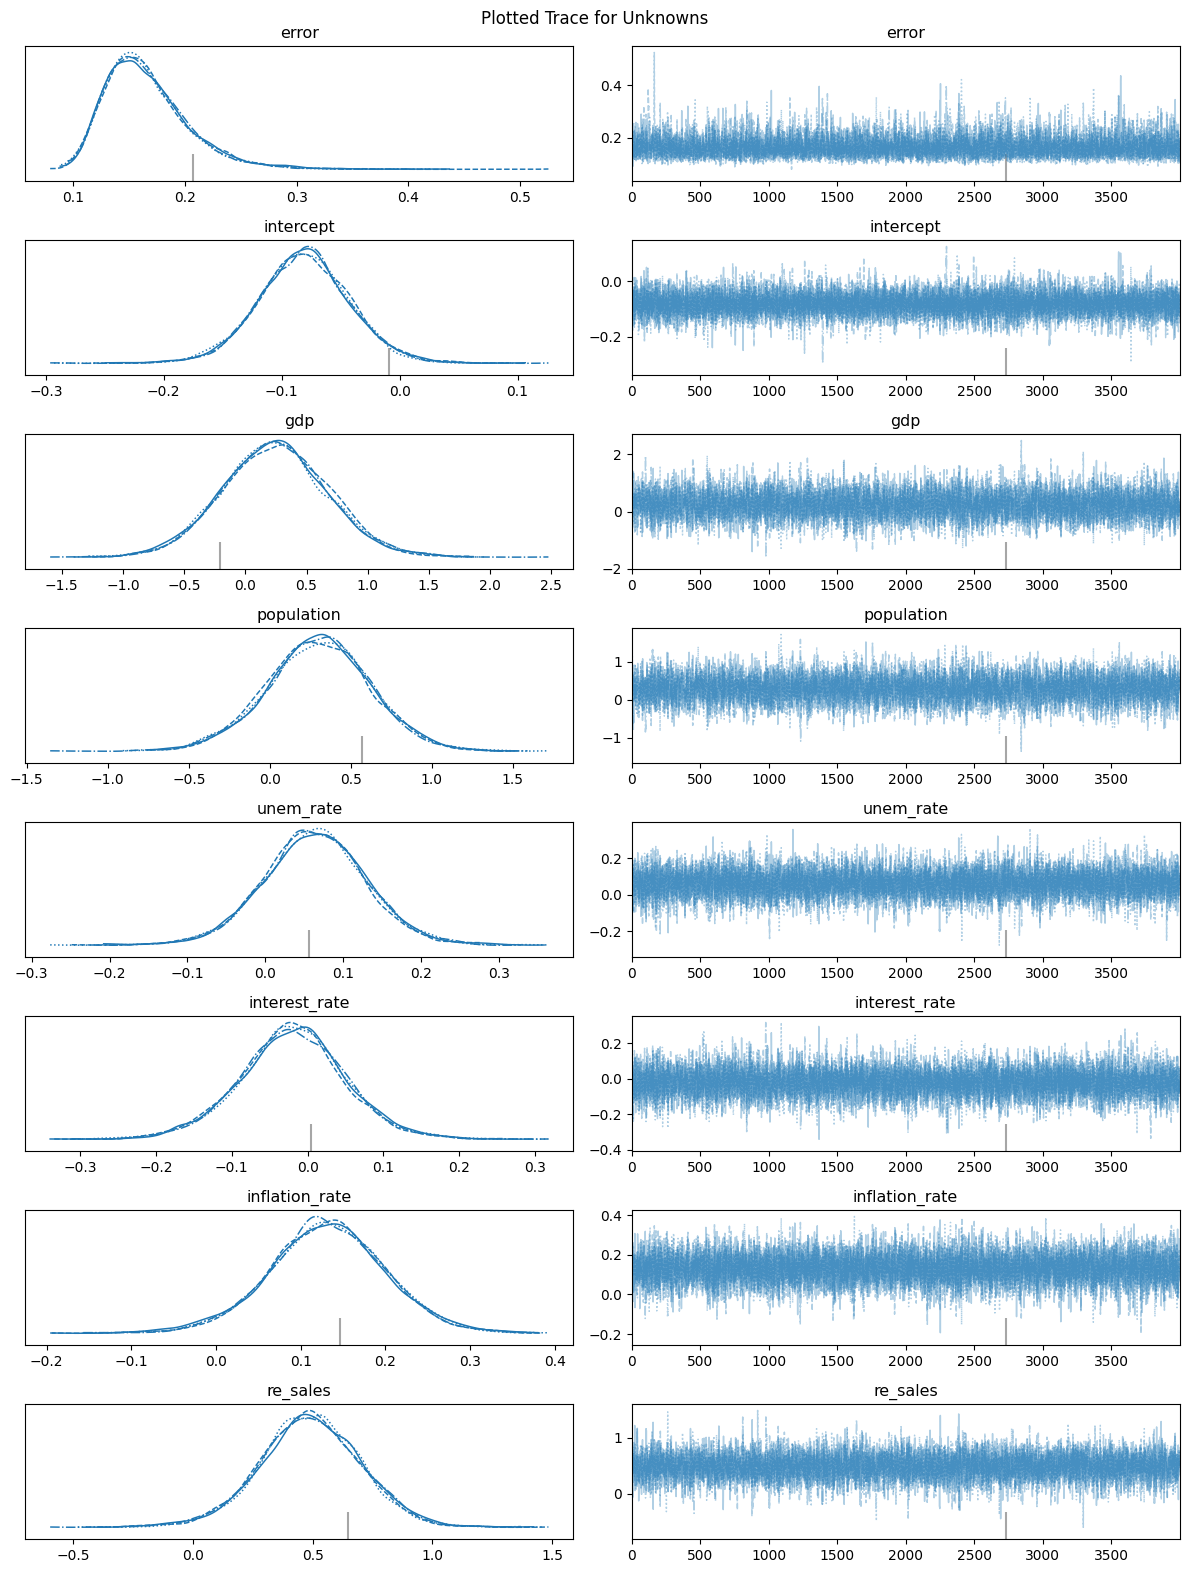

In [27]:
ax = pm.plot_trace(simulated_trace)
ax[0][0].get_figure().suptitle('Plotted Trace for Unknowns')
plt.tight_layout()
plt.show()

In [28]:
# simulate our next output
with simulated_model:
    n_data = {
        'gdp_o' : x_test['gdp'],
        'population_o' : x_test['population'],
        'unem_rate_o' : x_test['unemployment_rate'],
        'interest_rate_o' : x_test['interest_rate'],
        'inflation_rate_o' : x_test['inflation_rate'],
        're_sales_o' : x_test['real_estate_sales']
         
    }

    pm.set_data(n_data)
    posterior = pm.sample_posterior_predictive(simulated_trace)

Sampling: [res]


In [29]:
chains = [posterior.posterior_predictive.res[i][:, 0] for i in range(4)]

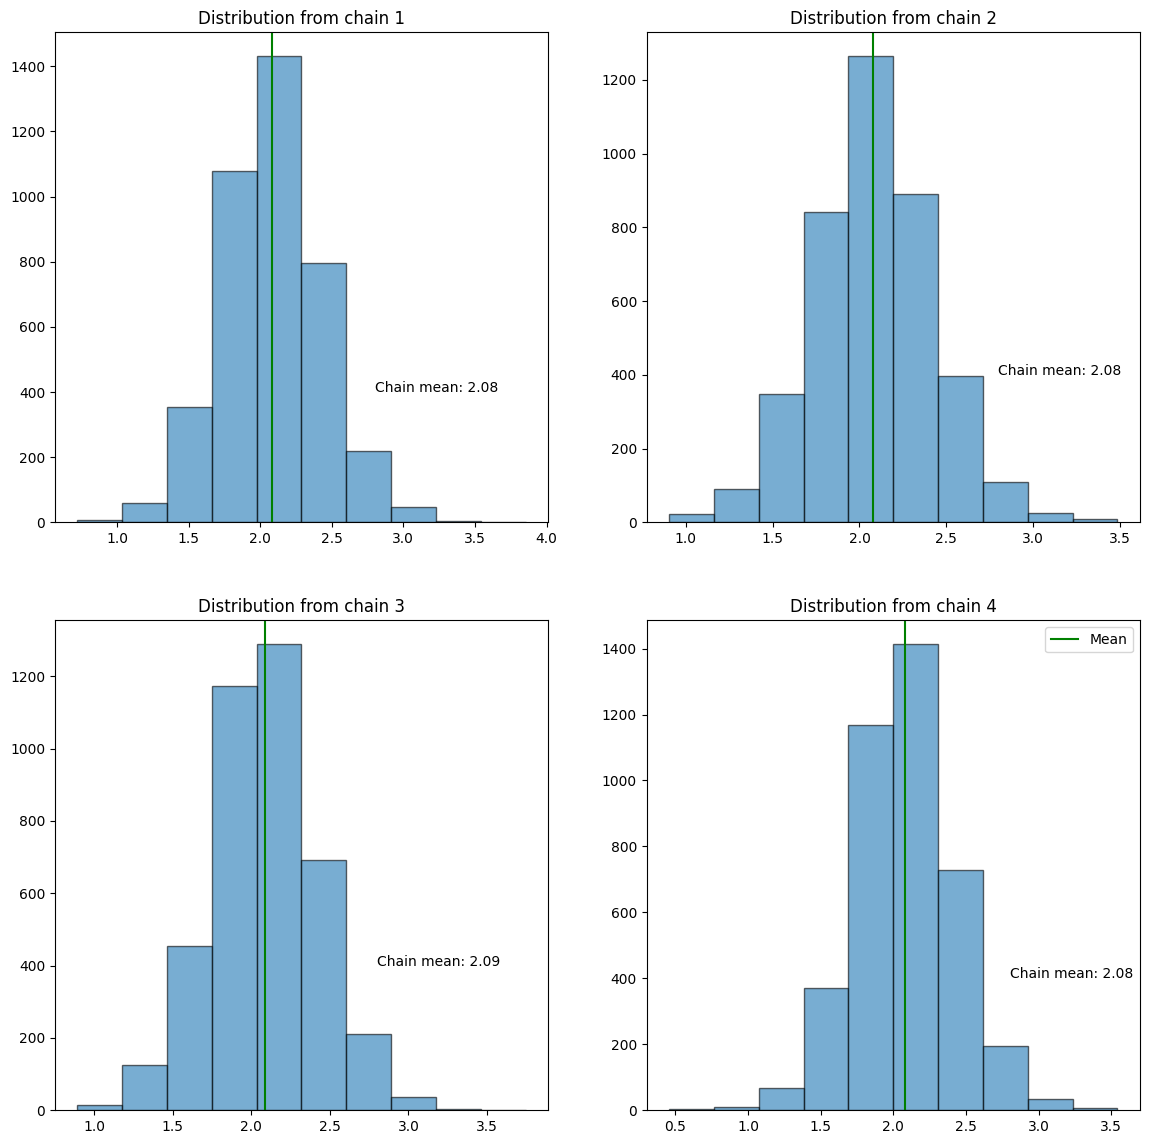

In [30]:
# plot all 4 chain distributions

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(4):
    ax[i // 2][i % 2].hist(chains[i], edgecolor='black', alpha=0.6)
    ax[i // 2][i % 2].set_title(f'Distribution from chain {i + 1}')
    ax[i // 2][i % 2].axvline(chains[i].mean(), c='g', label='Mean')
    ax[i // 2][i % 2].text(2.8, 400, f'Chain mean: {chains[i].mean().values:.2f}')

plt.legend()
plt.show()

In [373]:
chains[0].std().values

array(0.32231884)

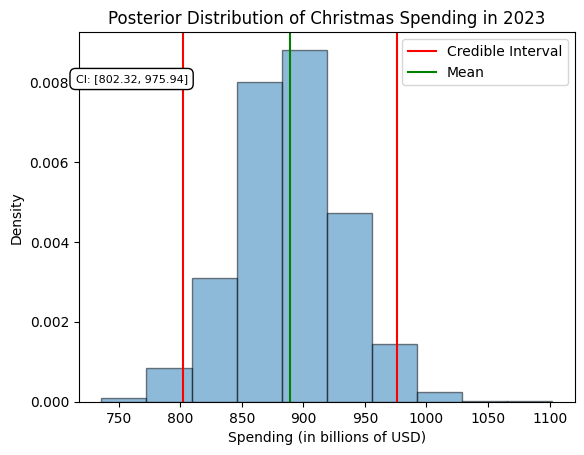

In [32]:
curr_chain = chains[2].values.copy()

curr_chain *= sigma_y
curr_chain += mu_y

plt.hist(curr_chain, edgecolor='k', alpha=0.5, density=True)

plt.axvline(curr_chain.mean() - 2 * curr_chain.std(), c='red')
plt.axvline(curr_chain.mean() + 2 * curr_chain.std(), c='red', label='Credible Interval')
plt.axvline(curr_chain.mean(), c='g', label='Mean')

# Add text box
plt.text(715, 0.008, f'CI: [{(curr_chain.mean() - 2 * curr_chain.std()):.2f}, {(curr_chain.mean() + 2 * curr_chain.std()):.2f}]', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.legend()

plt.xlabel('Spending (in billions of USD)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Christmas Spending in 2023')
plt.show()


In [411]:
x_train_pca

,Component 1,Component 2
0,-9.820167,0.066523
1,-8.716751,1.013128
2,-7.685362,1.915032
3,-6.686969,2.051952
4,-5.623798,2.174067
5,-4.707798,-1.035707
6,-3.817668,-1.796019
7,-2.820081,-1.920688
8,-1.725917,-1.162752
9,-0.668544,-1.383343


### PCA

In [444]:
with pm.Model() as pca_model:
    # set distirbutions
    error = pm.Cauchy('error', 0, 1)
    intercept = pm.Normal('intercept', 0, 1)

    # initialize weights
    b1 = pm.Normal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)

    # create data components
    first_ppc = pm.MutableData('ppc_1', x_train_pca['Component 1'].values)
    second_ppc = pm.MutableData('ppc_2', x_train_pca['Component 2'].values)

    res = pm.Normal('res', b1 * first_ppc + b2 * second_ppc + intercept, error, observed=y)

    

In [445]:
with pca_model:
    pca_trace = pm.sample(draws=4000, tune=5000, chains=4, target_accept=0.90, random_state=109) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, b1, b2]


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 4 seconds.


In [446]:
y

array([-1.29456291, -1.07495685, -0.86128608, -0.74183819, -0.63871237,
       -0.8204809 , -0.81157795, -0.61793882, -0.43617029, -0.33007682,
       -0.21433849, -0.00734493,  0.11803826,  0.25677587,  0.49567166,
        0.58395923,  0.77759837,  1.26280906,  1.99952806,  2.35490409])

In [447]:
with pca_model:
    hat_data_pca = pm.sample_posterior_predictive(pca_trace)
hat_data_pca.posterior_predictive.res[0, :, :].mean(axis=0)

Sampling: [res]


<xarray.DataArray 'res' (res_dim_2: 20)>
array([-1.4950973 , -1.16009078, -0.85459916, -0.67407137, -0.48640923,
       -0.89260222, -0.8956915 , -0.76128298, -0.45814377, -0.33706468,
       -0.14228265,  0.08245427,  0.22367606,  0.46578856,  0.73443998,
        0.97059288,  1.0799067 ,  0.93343293,  1.60416464,  2.09130049])
Coordinates:
    chain      int64 0
  * res_dim_2  (res_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

In [448]:
pm.summary(pca_trace, var_names=['intercept', 'error', 'b1', 'b2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.000,0.054,-0.099,0.104,0.0,0.0,16234.0,10580.0,1.0
error,0.235,0.045,0.161,0.318,0.0,0.0,11753.0,7877.0,1.0
b1,0.153,0.009,0.136,0.170,0.0,0.0,16170.0,10418.0,1.0
b2,0.170,0.037,0.100,0.243,0.0,0.0,15981.0,10981.0,1.0


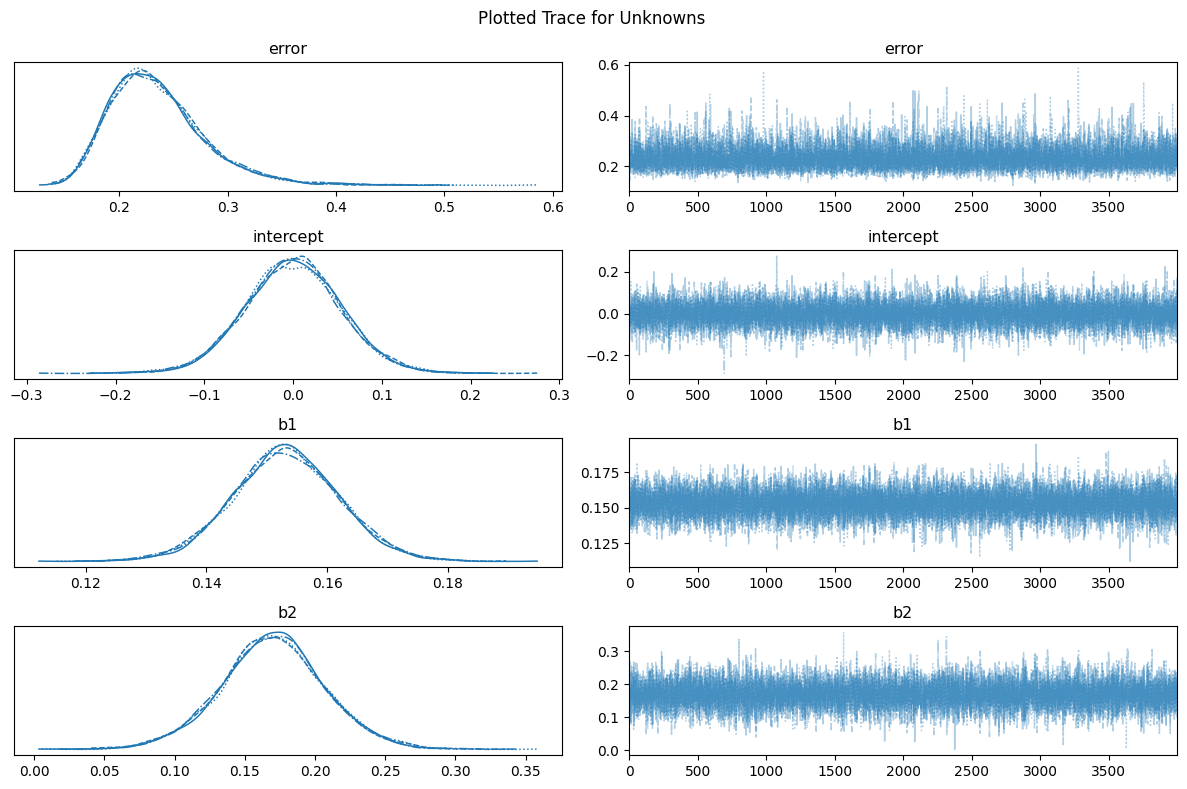

In [449]:
ax = pm.plot_trace(pca_trace)
ax[0][0].get_figure().suptitle('Plotted Trace for Unknowns')
plt.tight_layout()
plt.show()

In [450]:
x_test_pca

,Component 1,Component 2
0,11.060575,2.24418


In [451]:
# simulate our next output
with pca_model:
    n_data = {
        'ppc_1' : x_test_pca['Component 1'],
        'ppc_2' : x_test_pca['Component 2'],
    }

    pm.set_data(n_data)
    posterior_pca = pm.sample_posterior_predictive(pca_trace)

chains = [posterior_pca.posterior_predictive.res[i][:, 0] for i in range(4)]

Sampling: [res]


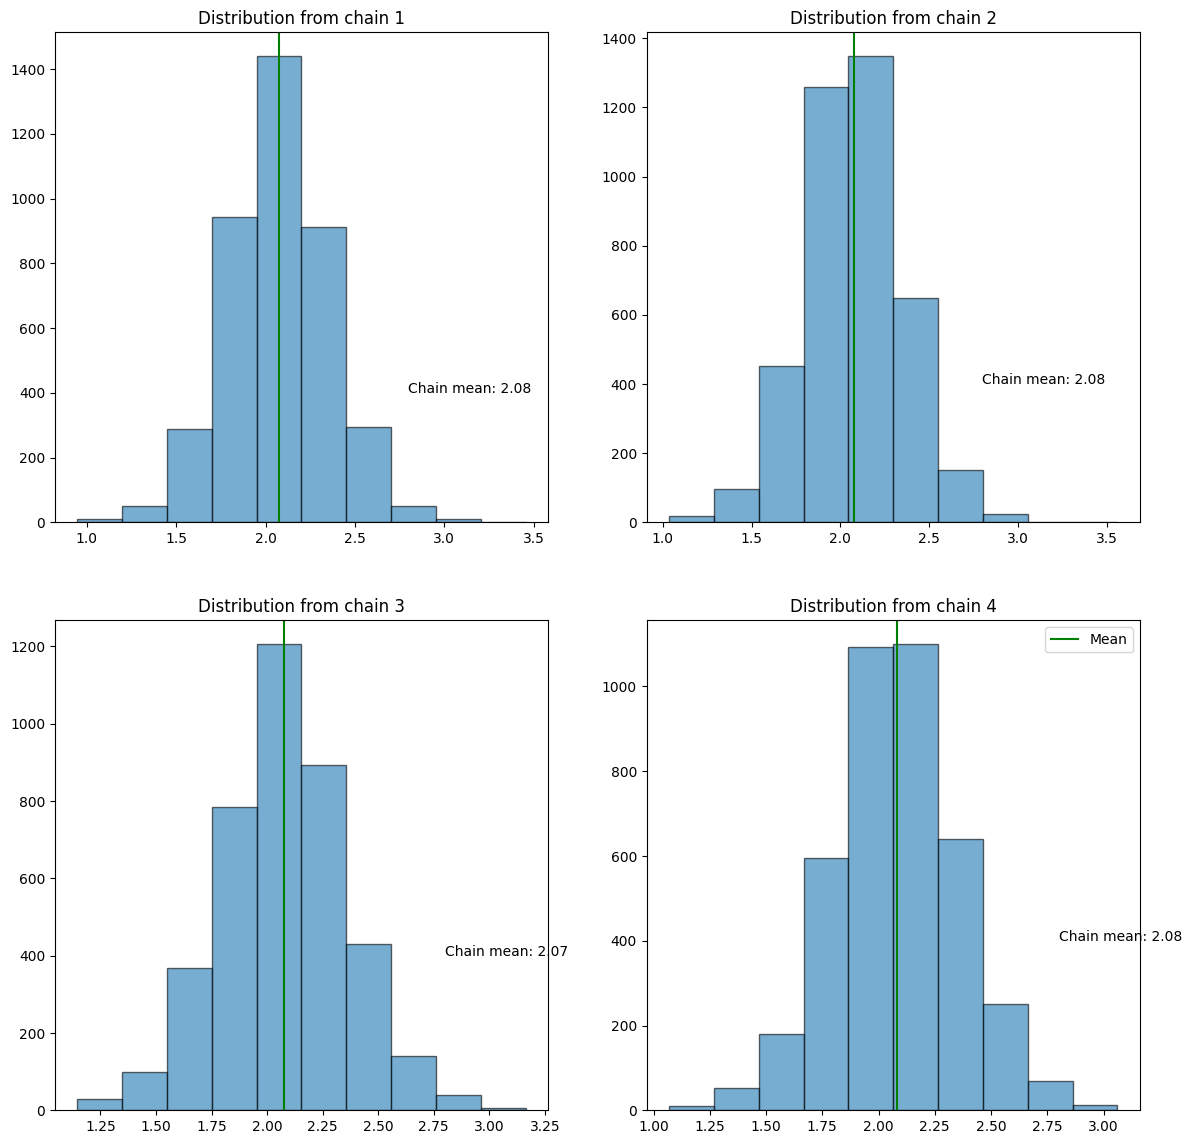

In [452]:
# plot all 4 chain distributions

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(4):
    ax[i // 2][i % 2].hist(chains[i], edgecolor='black', alpha=0.6)
    ax[i // 2][i % 2].set_title(f'Distribution from chain {i + 1}')
    ax[i // 2][i % 2].axvline(chains[i].mean(), c='g', label='Mean')
    ax[i // 2][i % 2].text(2.8, 400, f'Chain mean: {chains[i].mean().values:.2f}')

plt.legend()
plt.show()

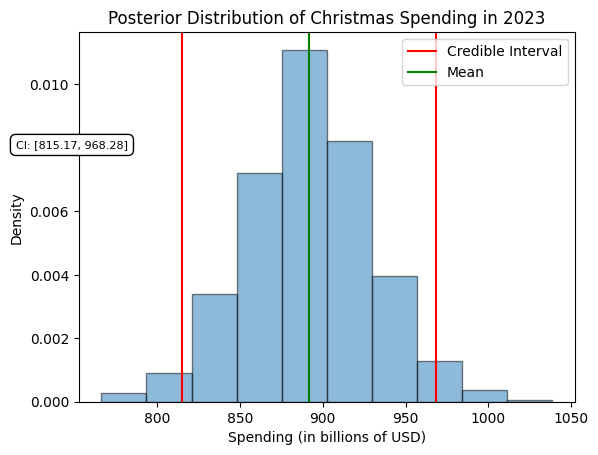

In [453]:
curr_chain = chains[2].values.copy()

curr_chain *= sigma_y
curr_chain += mu_y

plt.hist(curr_chain, edgecolor='k', alpha=0.5, density=True)

plt.axvline(curr_chain.mean() - 2 * curr_chain.std(), c='red')
plt.axvline(curr_chain.mean() + 2 * curr_chain.std(), c='red', label='Credible Interval')
plt.axvline(curr_chain.mean(), c='g', label='Mean')

# Add text box
plt.text(715, 0.008, f'CI: [{(curr_chain.mean() - 2 * curr_chain.std()):.2f}, {(curr_chain.mean() + 2 * curr_chain.std()):.2f}]', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.legend()

plt.xlabel('Spending (in billions of USD)')
plt.ylabel('Density')
plt.title('Posterior Distribution of Christmas Spending in 2023')
plt.show()
